In [1]:
import sys
sys.path.append("../data-science-from-scratch")

NameError: name 'inputs' is not defined

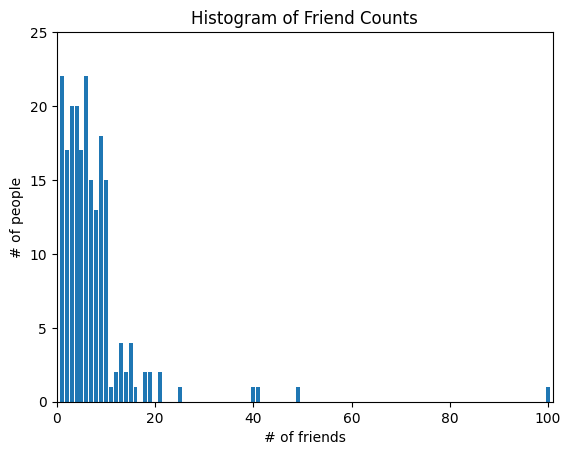

In [2]:
from scratch.linear_algebra import dot, Vector

def predict(x: Vector, beta: Vector) -> float:
    """assumes that the first element of x is 1""" [cite: 27]
    return dot(x, beta)


from typing import List

def error(x: Vector, y: float, beta: Vector) -> float:
    return predict(x, beta) - y 


def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2 


def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    err = error(x, y, beta) 
    return [2 * err * x_i for x_i in x] 


import random
import tqdm
from scratch.linear_algebra import vector_mean
from scratch.gradient_descent import gradient_step

def least_squares_fit(xs: List[Vector],
                      ys: List[float],
                      learning_rate: float = 0.001,
                      num_steps: int = 1000,
                      batch_size: int = 1) -> Vector:
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """ 
    # Start with a random guess [cite: 99]
    guess = [random.random() for _ in xs[0]] 

    for _ in tqdm.trange(num_steps, desc="least squares fit"): 
        for start in range(0, len(xs), batch_size): 
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)]) 
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess 

from scratch.statistics import daily_minutes_good
from scratch.gradient_descent import gradient_step

random.seed(0) 
# This will run for a while. 
learning_rate = 0.001 

beta = least_squares_fit(inputs, daily_minutes_good, learning_rate, 5000, 25) 

assert 30.50 < beta[0] < 30.70  # constant 
assert 0.96 < beta[1] < 1.00    # num friends 
assert -1.88 < beta[2] < -1.85  # work hours per day 
assert 0.91 < beta[3] < 0.94    # has PhD 


from scratch.simple_linear_regression import total_sum_of_squares

def multiple_r_squared(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    sum_of_squared_errors = sum(error(x, y, beta) ** 2
                                for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys) 



from typing import TypeVar, Callable

X = TypeVar('X') # Generic type for data 
Stat = TypeVar('Stat') # Generic type for "statistic" 

def bootstrap_sample(data: List[X]) -> List[X]:
    """randomly samples len(data) elements with replacement""" 
    return [random.choice(data) for _ in data] 

def bootstrap_statistic(data: List[X],
                        stats_fn: Callable[[List[X]], Stat],
                        num_samples: int) -> List[Stat]:
    """evaluates stats_fn on num_samples bootstrap samples from data""" 
    return [stats_fn(bootstrap_sample(data)) for _ in range(num_samples)]


# 101 points all very close to 100 
close_to_100 = [99.5 + random.random() for _ in range(101)] 

# 101 points, 50 of them near 0, 50 of them near 200 
far_from_100 = ([99.5 + random.random()] +
                [random.random() for _ in range(50)] + 
                [200 + random.random() for _ in range(50)]) 

from scratch.statistics import median, standard_deviation

medians_close = bootstrap_statistic(close_to_100, median, 100) 

medians_far = bootstrap_statistic(far_from_100, median, 100) 


from typing import Tuple
import datetime

def estimate_sample_beta(pairs: List[Tuple[Vector, float]]):
    x_sample = [x for x, _ in pairs] 
    y_sample = [y for _, y in pairs] 
    beta = least_squares_fit(x_sample, y_sample, learning_rate, 5000, 25) 
    print("bootstrap sample", beta) 
    return beta


random.seed(0) # so that you get the same results as me 

# This will take a couple of minutes! 
bootstrap_betas = bootstrap_statistic(list(zip(inputs, daily_minutes_good)),
                                      estimate_sample_beta,
                                      100) 

bootstrap_standard_errors = [
    standard_deviation([beta[i] for beta in bootstrap_betas]) 
    for i in range(4)] 

print(bootstrap_standard_errors) 
# [1.272,      # constant term, actual error = 1.19 
#  0.103,      # num_friends, actual error = 0.080 
#  0.155,      # work_hours, actual error = 0.127 
#  1.249]      # phd, actual error = 0.998 

from scratch.probability import normal_cdf

def p_value(beta_hat_j: float, sigma_hat_j: float) -> float:
    if beta_hat_j > 0:
        # if the coefficient is positive, we need to compute twice the
        # probability of seeing an even larger value 
        return 2 * (1 - normal_cdf(beta_hat_j / sigma_hat_j)) 
    else:
        # otherwise twice the probability of seeing a *smaller* value 
        return 2 * normal_cdf(beta_hat_j / sigma_hat_j)
    
assert p_value(30.58, 1.27) < 0.001  # constant term 
assert p_value(0.972, 0.103) < 0.001 # num_friends 
assert p_value(-1.865, 0.155) < 0.001 # work_hours 
assert p_value(0.923, 1.249) > 0.4    # phd 

# alpha is a hyperparameter controlling how harsh the penalty is. 
def ridge_penalty(beta: Vector, alpha: float) -> float:
    return alpha * dot(beta[1:], beta[1:]) 

def squared_error_ridge(x: Vector,
                          y: float,
                          beta: Vector,
                          alpha: float) -> float:
    """estimate error plus ridge penalty on beta""" 
    return error(x, y, beta)**2 + ridge_penalty(beta, alpha) 


from scratch.linear_algebra import add

def ridge_penalty_gradient(beta: Vector, alpha: float) -> Vector:
    """gradient of just the ridge penalty""" 
    return [0.] + [2 * alpha * beta_j for beta_j in beta[1:]] 

# With alpha = 0.0 (no penalty) 
random.seed(0) 
beta_0 = least_squares_fit_ridge(inputs, daily_minutes_good, 0.0, # alpha 
                                 learning_rate, 5000, 25) 
# [30.51, 0.97, -1.85, 0.91] 

# With alpha = 0.1 
beta_0_1 = least_squares_fit_ridge(inputs, daily_minutes_good, 0.1, # alpha 
                                   learning_rate, 5000, 25) 
# [30.8, 0.95, -1.83, 0.54] 

# With alpha = 1 
beta_1 = least_squares_fit_ridge(inputs, daily_minutes_good, 1, # alpha 
                                 learning_rate, 5000, 25) 
# [30.6, 0.90, -1.68, 0.10] 

# With alpha = 10 
beta_10 = least_squares_fit_ridge(inputs, daily_minutes_good, 10, # alpha 
                                  learning_rate, 5000, 25)
# [28.3, 0.67, -0.90, -0.01] 

def lasso_penalty(beta, alpha):
    return alpha * sum(abs(beta_i) for beta_i in beta[1:]) 


In [13]:
# 1. IMPORTS
import random
import math
from typing import List, Tuple, Callable, TypeVar

# A Vector is defined as a list of floating-point numbers.
Vector = List[float]


# 2. HELPER FUNCTIONS (Implementing the 'scratch' library)

def dot(v: Vector, w: Vector) -> float:
    """Computes the dot product of two vectors."""
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def vector_mean(vectors: List[Vector]) -> Vector:
    """Computes the component-wise mean of a list of vectors."""
    n = len(vectors)
    return [sum(vector[i] for vector in vectors) / n for i in range(len(vectors[0]))]

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`."""
    assert len(v) == len(gradient)
    step = [step_size * g_i for g_i in gradient]
    return [v_i + s_i for v_i, s_i in zip(v, step)]

def total_sum_of_squares(y: List[float]) -> float:
    """The total squared variation of y_i's from their mean."""
    mean_y = sum(y) / len(y)
    return sum((y_i - mean_y) ** 2 for y_i in y)

def standard_deviation(xs: List[float]) -> float:
    """The standard deviation of a list of numbers."""
    n = len(xs)
    if n < 2: return 0 # Standard deviation is 0 for lists with 0 or 1 elements
    mean_xs = sum(xs) / n
    variance = sum([(x - mean_xs) ** 2 for x in xs]) / (n - 1)
    return math.sqrt(variance)

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    """Cumulative distribution function for the normal distribution."""
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


# 3. FEATURE SCALING (NEW SECTION TO FIX THE ERROR)

def scale(data: List[Vector]) -> Tuple[List[Vector], List[float], List[float]]:
    """Scales the input data and returns the scaled data, means, and standard deviations."""
    num_cols = len(data[0])
    means = [sum(row[j] for row in data) / len(data) for j in range(num_cols)]
    stdevs = [standard_deviation([row[j] for row in data]) for j in range(num_cols)]

    scaled_data = [list(row) for row in data] # Make a mutable copy
    for row in scaled_data:
        for j in range(num_cols):
            if stdevs[j] > 0:
                row[j] = (row[j] - means[j]) / stdevs[j]
    
    return scaled_data, means, stdevs


# 4. CORE REGRESSION MODEL

def predict(x: Vector, beta: Vector) -> float:
    """Assumes that the first element of x is 1."""
    return dot(x, beta)

def error(x: Vector, y: float, beta: Vector) -> float:
    """The error from predicting beta for the input x."""
    return y - predict(x, beta)

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    """The squared error corresponding to the prediction."""
    return error(x, y, beta) ** 2

def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    """The gradient of the squared error."""
    err = error(x, y, beta)
    return [-2 * err * x_i for x_i in x]


# 5. GRADIENT DESCENT FITTING

def least_squares_fit(xs: List[Vector],
                      ys: List[float],
                      learning_rate: float = 0.01, # Can now use a larger learning rate
                      num_steps: int = 1000,
                      batch_size: int = 1) -> Vector:
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    guess = [random.random() for _ in xs[0]]

    for step in range(num_steps):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start + batch_size]
            batch_ys = ys[start:start + batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess


# 6. MODEL EVALUATION

def multiple_r_squared(xs: List[Vector], ys: List[float], beta: Vector) -> float:
    """
    The fraction of variation in y captured by the model.
    """
    sum_of_squared_errors = sum(squared_error(x, y, beta) for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys)


# 7. MAIN EXECUTION BLOCK

if __name__ == "__main__":
    print("### Multiple Regression Analysis ###")

    # Raw data
    inputs = [
        [1, 49, 4, 0], [1, 41, 9, 0], [1, 25, 5, 1], [1, 52, 5, 0],
        [1, 35, 2, 1], [1, 60, 3, 0], [1, 55, 6, 0], [1, 20, 4, 1],
        [1, 39, 4, 0], [1, 44, 6, 1], [1, 30, 5, 0], [1, 45, 7, 0]
    ]
    daily_minutes_good = [68.77, 51.25, 52.08, 70.71, 48.53, 75.3, 62.4, 37.1, 58.2, 65.5, 49.3, 68.1]

    # --- Scale the data (excluding the constant term) ---
    input_features = [row[1:] for row in inputs]
    scaled_features, means, stdevs = scale(input_features)
    
    # Re-attach the constant term
    scaled_inputs = [[1] + row for row in scaled_features]

    # --- Standard Multiple Regression on Scaled Data ---
    print("\n--- Fitting Standard Multiple Regression Model ---")
    random.seed(0)
    # Train on scaled data. A higher learning rate is now stable.
    beta_scaled = least_squares_fit(scaled_inputs, daily_minutes_good, learning_rate=0.01, num_steps=5000, batch_size=4)

    # To interpret the model, we need to unscale the coefficients.
    # beta_unscaled_j = beta_scaled_j / stdev_j
    # beta_unscaled_0 = beta_scaled_0 - sum(beta_scaled_j * mean_j / stdev_j)
    beta_unscaled = [0.0] * len(beta_scaled)
    for j in range(1, len(beta_scaled)):
        beta_unscaled[j] = beta_scaled[j] / stdevs[j-1]

    beta_unscaled[0] = beta_scaled[0] - sum(beta_unscaled[j] * means[j-1] for j in range(1, len(beta_scaled)))

    print(f"Coefficients (beta): {[round(b, 2) for b in beta_unscaled]}")
    print(f"R-squared: {multiple_r_squared(inputs, daily_minutes_good, beta_unscaled):.3f}")

### Multiple Regression Analysis ###

--- Fitting Standard Multiple Regression Model ---
Coefficients (beta): [23.58, 0.86, -0.12, 0.85]
R-squared: 0.803
